#  Fish Growth Estimation from Larvae Statics

In [1]:
#imporitng libraries

In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os
import joblib
from sklearn.decomposition import PCA

In [3]:
#uploading dataset

In [4]:
df = pd.read_csv(r'dataset/fishlarvae_Bon_pro.csv')
df

,cruise_id,year,brief_desc,haul_id,lat,lon,yrday0_local,day_local,month_local,time_local,...,common_name,sample,length,size_class,prot_total,RNA,DNA,growth,RNA_DNA,prot_predicted
0,AL9306,1993,process,3,40.80,-68.0000,138,19,5,728,...,Atlantic_cod,5.0,8.34245,3.0,579.19,69.07,14.65,0.124,4.72,305.64
1,AL9306,1993,process,3,40.80,-68.0000,138,19,5,728,...,Atlantic_cod,7.0,7.87592,3.0,322.18,36.54,7.77,0.123,4.70,163.48
2,AL9306,1993,process,3,40.80,-68.0000,138,19,5,728,...,haddock,2.0,7.17796,3.0,215.68,29.97,5.95,0.138,5.04,115.86
3,AL9306,1993,process,3,40.80,-68.0000,138,19,5,728,...,haddock,4.0,7.5245,3.0,403.88,58.20,12.90,0.115,4.51,254.81
4,AL9306,1993,process,3,40.80,-68.0000,138,19,5,728,...,haddock,8.0,8.7023,3.0,472.57,74.21,15.85,0.122,4.68,314.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8905,SJ9507,1995,process,185,40.62,-68.5533,133,14,5,711,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8906,SJ9507,1995,process,185,40.62,-68.5533,133,14,5,711,...,Atlantic_cod,1764.0,12.91,3.0,1130.85,166.90,35.00,0.128,4.77,726.36
8907,SJ9507,1995,process,185,40.62,-68.5533,133,14,5,711,...,Atlantic_cod,1765.0,10.82,3.0,692.64,105.28,24.48,0.107,4.30,508.91
8908,SJ9507,1995,process,185,40.62,-68.5530,133,14,5,711,...,Atlantic_cod,1766.0,6.18905,2.0,117.00,22.38,5.82,0.086,3.85,123.21


In [5]:
#data analysis

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8910 entries, 0 to 8909
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   cruise_id       8910 non-null   object 
 1   year            8910 non-null   int64  
 2   brief_desc      8910 non-null   object 
 3   haul_id         8910 non-null   int64  
 4   lat             8910 non-null   float64
 5   lon             8910 non-null   float64
 6   yrday0_local    8910 non-null   int64  
 7   day_local       8910 non-null   int64  
 8   month_local     8910 non-null   int64  
 9   time_local      8910 non-null   int64  
 10  length_day      8760 non-null   float64
 11  temp_avg        8760 non-null   float64
 12  sal_avg         8760 non-null   object 
 13  sigma_t_avg     8760 non-null   object 
 14  depth_w         8760 non-null   float64
 15  depth_tow_max   8760 non-null   float64
 16  common_name     8760 non-null   object 
 17  sample          8760 non-null   f

In [7]:
df.describe()

,year,haul_id,lat,lon,yrday0_local,day_local,month_local,time_local,length_day,temp_avg,depth_w,depth_tow_max,sample,size_class,RNA,DNA,growth,RNA_DNA,prot_predicted
count,8910.000000,8910.000000,8910.000000,8910.000000,8910.000000,8910.000000,8910.000000,8910.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,1997.330864,56.034792,40.927347,-67.533853,115.381594,11.904153,4.482828,1166.832323,14.673523,5.849979,71.405936,67.573973,106043.492237,1.866667,20.616331,5.648470,0.063306,3.492900,114.745646
std,1.738571,39.299883,0.184337,0.384391,16.383545,3.988593,0.514344,652.125353,0.713224,1.178394,13.818158,13.851899,302796.701914,0.691826,21.366403,5.176331,0.029960,0.575908,106.085357
min,1993.000000,1.000000,40.516670,-68.680000,74.000000,5.000000,3.000000,5.000000,12.820000,4.112000,40.000000,36.000000,1.000000,1.000000,1.150000,0.290000,-0.051000,1.170000,2.580000
25%,1997.000000,23.000000,40.793000,-67.800000,99.000000,9.000000,4.000000,621.000000,13.970000,4.814000,62.000000,58.000000,878.750000,1.000000,7.007500,2.060000,0.043000,3.140000,40.740000
50%,1997.000000,51.000000,40.918300,-67.483000,106.000000,11.000000,4.000000,1139.000000,14.280000,5.777000,71.000000,67.000000,3160.000000,2.000000,14.020000,3.980000,0.066000,3.500000,81.305000
75%,1999.000000,79.000000,41.037000,-67.242000,130.000000,16.000000,5.000000,1701.000000,15.330000,6.563000,83.000000,78.000000,4304.250000,2.000000,26.285000,7.400000,0.082250,3.830000,151.730000
max,1999.000000,185.000000,41.878330,-66.553300,140.000000,21.000000,5.000000,2359.000000,15.680000,12.441000,105.000000,101.000000,991215.000000,3.000000,193.440000,40.080000,0.194000,6.740000,831.360000


In [8]:
#Checking NULL values

In [9]:
df.isnull().sum()

cruise_id           0
year                0
brief_desc          0
haul_id             0
lat                 0
lon                 0
yrday0_local        0
day_local           0
month_local         0
time_local          0
length_day        150
temp_avg          150
sal_avg           150
sigma_t_avg       150
depth_w           150
depth_tow_max     150
common_name       150
sample            150
length            150
size_class        150
prot_total        150
RNA               150
DNA               150
growth            150
RNA_DNA           150
prot_predicted    150
dtype: int64

In [10]:
df = df.replace('nd', np.nan)
df.dropna(inplace=True)
df

,cruise_id,year,brief_desc,haul_id,lat,lon,yrday0_local,day_local,month_local,time_local,...,common_name,sample,length,size_class,prot_total,RNA,DNA,growth,RNA_DNA,prot_predicted
0,AL9306,1993,process,3,40.8000,-68.0000,138,19,5,728,...,Atlantic_cod,5.0,8.34245,3.0,579.19,69.07,14.65,0.124,4.72,305.64
1,AL9306,1993,process,3,40.8000,-68.0000,138,19,5,728,...,Atlantic_cod,7.0,7.87592,3.0,322.18,36.54,7.77,0.123,4.70,163.48
2,AL9306,1993,process,3,40.8000,-68.0000,138,19,5,728,...,haddock,2.0,7.17796,3.0,215.68,29.97,5.95,0.138,5.04,115.86
3,AL9306,1993,process,3,40.8000,-68.0000,138,19,5,728,...,haddock,4.0,7.5245,3.0,403.88,58.20,12.90,0.115,4.51,254.81
4,AL9306,1993,process,3,40.8000,-68.0000,138,19,5,728,...,haddock,8.0,8.7023,3.0,472.57,74.21,15.85,0.122,4.68,314.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8903,SJ9507,1995,process,183,40.7583,-68.6800,133,14,5,527,...,Atlantic_cod,1761.0,10.6,3.0,771.84,129.88,29.56,0.115,4.39,613.92
8906,SJ9507,1995,process,185,40.6200,-68.5533,133,14,5,711,...,Atlantic_cod,1764.0,12.91,3.0,1130.85,166.90,35.00,0.128,4.77,726.36
8907,SJ9507,1995,process,185,40.6200,-68.5533,133,14,5,711,...,Atlantic_cod,1765.0,10.82,3.0,692.64,105.28,24.48,0.107,4.30,508.91
8908,SJ9507,1995,process,185,40.6200,-68.5530,133,14,5,711,...,Atlantic_cod,1766.0,6.18905,2.0,117.00,22.38,5.82,0.086,3.85,123.21


In [11]:
df.isnull().sum()

cruise_id         0
year              0
brief_desc        0
haul_id           0
lat               0
lon               0
yrday0_local      0
day_local         0
month_local       0
time_local        0
length_day        0
temp_avg          0
sal_avg           0
sigma_t_avg       0
depth_w           0
depth_tow_max     0
common_name       0
sample            0
length            0
size_class        0
prot_total        0
RNA               0
DNA               0
growth            0
RNA_DNA           0
prot_predicted    0
dtype: int64

In [12]:
#Label Encoding

In [13]:
le=LabelEncoder()
df['cruise_id']=le.fit_transform(df['cruise_id'])
df['brief_desc']=le.fit_transform(df['brief_desc'])
df['common_name']=le.fit_transform(df['common_name'])

In [14]:
#data Correlection

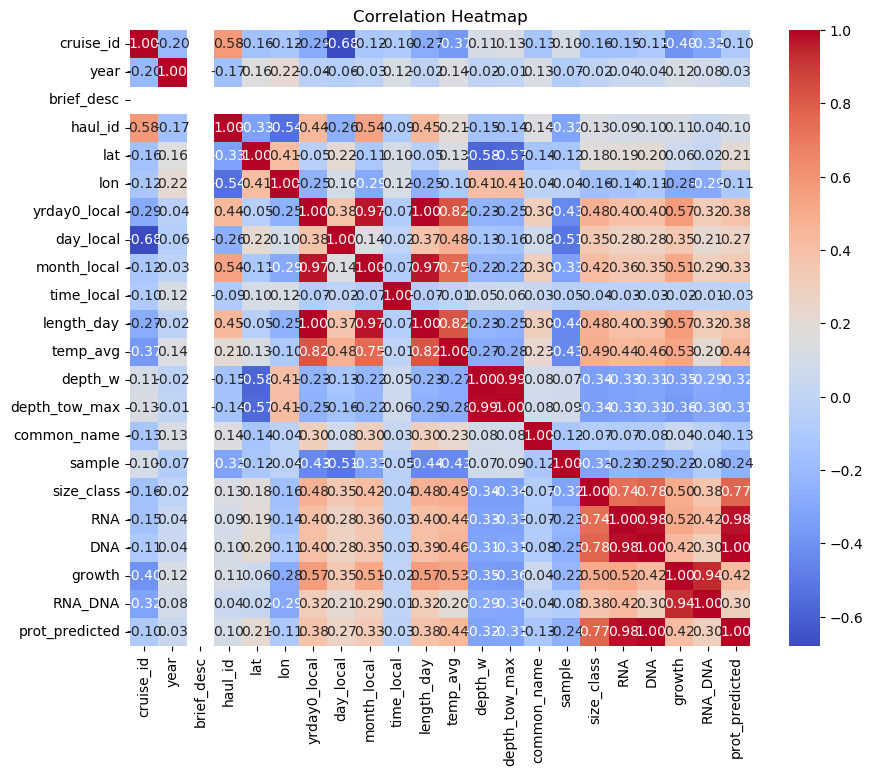

In [15]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [16]:
#Data Visulazation

In [17]:
df.columns

Index(['cruise_id', 'year', 'brief_desc', 'haul_id', 'lat', 'lon',
       'yrday0_local', 'day_local', 'month_local', 'time_local', 'length_day',
       'temp_avg', 'sal_avg', 'sigma_t_avg', 'depth_w', 'depth_tow_max',
       'common_name', 'sample', 'length', 'size_class', 'prot_total', 'RNA',
       'DNA', 'growth', 'RNA_DNA', 'prot_predicted'],
      dtype='object')

In [18]:
df['growth']


0       0.124
1       0.123
2       0.138
3       0.115
4       0.122
        ...  
8903    0.115
8906    0.128
8907    0.107
8908    0.086
8909    0.113
Name: growth, Length: 8272, dtype: float64

In [19]:
#Declaring independent and dependent variable

In [20]:
x = df.drop(['growth'],axis = 1)
x.head()

,cruise_id,year,brief_desc,haul_id,lat,lon,yrday0_local,day_local,month_local,time_local,...,depth_tow_max,common_name,sample,length,size_class,prot_total,RNA,DNA,RNA_DNA,prot_predicted
0,0,1993,0,3,40.8,-68.0,138,19,5,728,...,59.0,0,5.0,8.34245,3.0,579.19,69.07,14.65,4.72,305.64
1,0,1993,0,3,40.8,-68.0,138,19,5,728,...,59.0,0,7.0,7.87592,3.0,322.18,36.54,7.77,4.70,163.48
2,0,1993,0,3,40.8,-68.0,138,19,5,728,...,59.0,1,2.0,7.17796,3.0,215.68,29.97,5.95,5.04,115.86
3,0,1993,0,3,40.8,-68.0,138,19,5,728,...,59.0,1,4.0,7.5245,3.0,403.88,58.20,12.90,4.51,254.81
4,0,1993,0,3,40.8,-68.0,138,19,5,728,...,59.0,1,8.0,8.7023,3.0,472.57,74.21,15.85,4.68,314.03


In [21]:
y = df['growth']
y

0       0.124
1       0.123
2       0.138
3       0.115
4       0.122
        ...  
8903    0.115
8906    0.128
8907    0.107
8908    0.086
8909    0.113
Name: growth, Length: 8272, dtype: float64

In [22]:
pca = PCA(n_components=20)
x = pca.fit_transform(x)


In [23]:
#Data Splitting

In [24]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state = 42)

In [25]:
x_train.shape

(6617, 20)

In [26]:
#performance evalution

In [27]:
def performance_metrics(algorithm, predict, testY):
    mse = mean_squared_error(testY, predict)
    mae = mean_absolute_error(testY, predict)
    r2 = r2_score(testY, predict)

    print(algorithm + ' Mean Squared Error: {:.4f}'.format(mse))
    print(algorithm + ' Mean Absolute Error: {:.4f}'.format(mae))
    print(algorithm + ' R^2 Score: {:.4f}'.format(r2))

    # Plotting best-fit line
    plt.scatter(testY, predict)
    plt.plot([testY.min(), testY.max()], [testY.min(), testY.max()], '--r', lw=2)  # best-fit line
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title(algorithm + ' Predictions vs True Values')
    plt.show()


## CNN feature Extraction 

In [44]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score



# Separate features and target column
X = df.drop(columns=['growth']).values  # All features except the 'target'
y = df['growth'].values  # The 'target' column

# Split the dataset into training and test sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data (CNN generally works better with scaled data)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Reshape data to be compatible with Conv1D (samples, time steps, features)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

# Build a 1D CNN for feature extraction
def build_cnn_model(input_shape):
    model = Sequential()
    model.add(Conv1D(64, 2, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(128, 2, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    return model

# Define the CNN model
input_shape = (x_train.shape[1], 1)
cnn_model = build_cnn_model(input_shape)

# Extract features using the CNN model (ignore the final layer for feature extraction)
cnn_feature_extractor = Sequential(cnn_model.layers[:-1])  # Exclude the final dense layer

# Extract features from the CNN model
x_train_features = cnn_feature_extractor.predict(x_train)
x_test_features = cnn_feature_extractor.predict(x_test)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


## 30 % code


Support Vector Regressor Mean Squared Error: 0.0010
Support Vector Regressor Mean Absolute Error: 0.0246
Support Vector Regressor R^2 Score: -0.1090


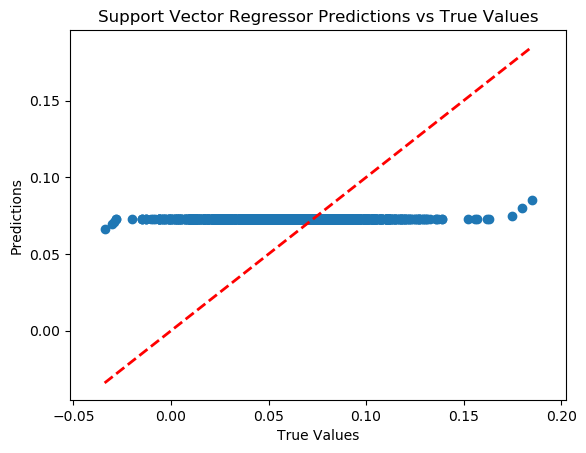

In [29]:
from sklearn.svm import SVR
import joblib
import os

svr_model_path = 'model/svr_model.joblib'  # Updated file extension to '.joblib'
if os.path.exists(svr_model_path):
    # Load the SVR model
    svr_model = joblib.load(svr_model_path)
    y_pred_svr = svr_model.predict(x_test)
else:
    # Train the SVR model
    svr_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)  # You can adjust parameters as needed
    svr_model.fit(x_train, y_train)

    # Save the trained SVR model
    joblib.dump(svr_model, svr_model_path)  # Corrected: pass the model object, not the path

# Predict using the trained SVR model
y_pred_svr = svr_model.predict(x_test)
# Evaluate the model
performance_metrics('Support Vector Regressor', y_pred_svr, y_test)


In [30]:
#XGBoost Model

XGBoost Regression Mean Squared Error: 0.0000
XGBoost Regression Mean Absolute Error: 0.0018
XGBoost Regression R^2 Score: 0.9900


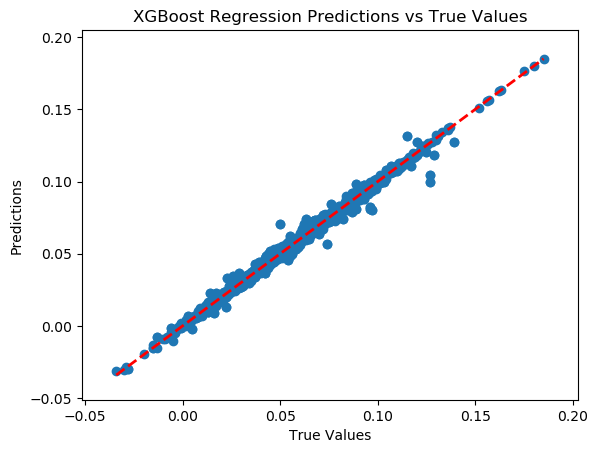

In [31]:
xgb_model = 'model/xgb.npy'
if os.path.exists(xgb_model):
    model2 = np.load(xgb_model, allow_pickle = True).item()
else:                       
    model2 = xgb.XGBRegressor()
    model2.fit(x_train, y_train)
    np.save('model/xgb', model2)

y_pred1 = model2.predict(x_test)
y_pred1
performance_metrics('XGBoost Regression', y_pred1, y_test)


In [32]:
y_pred1

array([0.07893749, 0.04247258, 0.08863214, ..., 0.02272021, 0.12732527,
       0.03131783], dtype=float32)

In [33]:
#Uploading testing dataset

In [34]:
Test=pd.read_csv("Dataset/test.csv")
Test

,cruise_id,year,brief_desc,haul_id,lat,lon,yrday0_local,day_local,month_local,time_local,...,depth_tow_max,common_name,sample,length,size_class,prot_total,RNA,DNA,RNA_DNA,prot_predicted
0,AL9306,1993,process,3,40.80,-68.00,138,19,5,728,...,59,Atlantic_cod,5,8.34245,3,579.1925,69.07161,14.645900,4.71611,305.64
1,AL9306,1993,process,3,40.80,-68.00,138,19,5,728,...,59,Atlantic_cod,7,7.87592,3,322.1819,36.54307,7.768259,4.70415,163.48
2,AL9306,1993,process,3,40.80,-68.00,138,19,5,728,...,59,haddock,2,7.17796,3,215.6828,29.96921,5.950875,5.03610,115.86
3,AL9306,1993,process,3,40.80,-68.00,138,19,5,728,...,59,haddock,4,7.52450,3,403.8845,58.19839,12.895000,4.51325,254.81
4,AL9306,1993,process,3,40.80,-68.00,138,19,5,728,...,59,haddock,8,8.70230,3,472.5697,74.20882,15.854380,4.68065,314.03
5,AL9306,1993,process,3,40.80,-68.00,138,19,5,728,...,59,haddock,9,7.92185,3,303.4084,53.49390,12.327240,4.33949,243.45
6,AL9306,1993,process,3,40.80,-68.00,138,19,5,728,...,59,haddock,10,5.95249,2,132.6644,18.72837,4.347738,4.30761,83.78
7,AL9306,1993,process,3,40.80,-68.00,138,19,5,728,...,59,haddock,11,6.64002,2,139.0110,21.84857,4.204845,5.19605,80.92
8,AL9306,1993,process,3,40.80,-68.00,138,19,5,728,...,59,haddock,12,6.33741,2,186.0650,32.34765,6.966398,4.64338,136.18
9,AL9306,1993,process,4,40.82,-67.78,138,19,5,932,...,63,Atlantic_cod,14,7.73348,3,253.0025,38.22225,8.644975,4.42133,181.60


In [35]:
test = Test
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   cruise_id       23 non-null     object 
 1   year            23 non-null     int64  
 2   brief_desc      23 non-null     object 
 3   haul_id         23 non-null     int64  
 4   lat             23 non-null     float64
 5   lon             23 non-null     float64
 6   yrday0_local    23 non-null     int64  
 7   day_local       23 non-null     int64  
 8   month_local     23 non-null     int64  
 9   time_local      23 non-null     int64  
 10  length_day      23 non-null     float64
 11  temp_avg        23 non-null     float64
 12  sal_avg         23 non-null     float64
 13  sigma_t_avg     23 non-null     float64
 14  depth_w         23 non-null     int64  
 15  depth_tow_max   23 non-null     int64  
 16  common_name     23 non-null     object 
 17  sample          23 non-null     int64

In [36]:
test.isnull().sum()

cruise_id         0
year              0
brief_desc        0
haul_id           0
lat               0
lon               0
yrday0_local      0
day_local         0
month_local       0
time_local        0
length_day        0
temp_avg          0
sal_avg           0
sigma_t_avg       0
depth_w           0
depth_tow_max     0
common_name       0
sample            0
length            0
size_class        0
prot_total        0
RNA               0
DNA               0
RNA_DNA           0
prot_predicted    0
dtype: int64

In [37]:
test = test.replace('nd', np.nan)
test.dropna(inplace=True)
test

,cruise_id,year,brief_desc,haul_id,lat,lon,yrday0_local,day_local,month_local,time_local,...,depth_tow_max,common_name,sample,length,size_class,prot_total,RNA,DNA,RNA_DNA,prot_predicted
0,AL9306,1993,process,3,40.80,-68.00,138,19,5,728,...,59,Atlantic_cod,5,8.34245,3,579.1925,69.07161,14.645900,4.71611,305.64
1,AL9306,1993,process,3,40.80,-68.00,138,19,5,728,...,59,Atlantic_cod,7,7.87592,3,322.1819,36.54307,7.768259,4.70415,163.48
2,AL9306,1993,process,3,40.80,-68.00,138,19,5,728,...,59,haddock,2,7.17796,3,215.6828,29.96921,5.950875,5.03610,115.86
3,AL9306,1993,process,3,40.80,-68.00,138,19,5,728,...,59,haddock,4,7.52450,3,403.8845,58.19839,12.895000,4.51325,254.81
4,AL9306,1993,process,3,40.80,-68.00,138,19,5,728,...,59,haddock,8,8.70230,3,472.5697,74.20882,15.854380,4.68065,314.03
5,AL9306,1993,process,3,40.80,-68.00,138,19,5,728,...,59,haddock,9,7.92185,3,303.4084,53.49390,12.327240,4.33949,243.45
6,AL9306,1993,process,3,40.80,-68.00,138,19,5,728,...,59,haddock,10,5.95249,2,132.6644,18.72837,4.347738,4.30761,83.78
7,AL9306,1993,process,3,40.80,-68.00,138,19,5,728,...,59,haddock,11,6.64002,2,139.0110,21.84857,4.204845,5.19605,80.92
8,AL9306,1993,process,3,40.80,-68.00,138,19,5,728,...,59,haddock,12,6.33741,2,186.0650,32.34765,6.966398,4.64338,136.18
9,AL9306,1993,process,4,40.82,-67.78,138,19,5,932,...,63,Atlantic_cod,14,7.73348,3,253.0025,38.22225,8.644975,4.42133,181.60


In [38]:
le=LabelEncoder()
test['cruise_id']=le.fit_transform(test['cruise_id'])
test['brief_desc']=le.fit_transform(test['brief_desc'])
test['common_name']=le.fit_transform(test['common_name'])

In [39]:
pca = PCA(n_components=20)
test = pca.fit_transform(test)


In [40]:
#Model prediction on test data

In [41]:
pred = model2.predict(test)
pred

array([0.05987383, 0.06631011, 0.0683765 , 0.05981905, 0.06166212,
       0.05990046, 0.06622887, 0.0684183 , 0.05946964, 0.05945465,
       0.05968604, 0.0591251 , 0.06896084, 0.0755578 , 0.05962521,
       0.05853113, 0.06141154, 0.06131719, 0.06165032, 0.07608112,
       0.06216926, 0.06445947, 0.05983103], dtype=float32)

In [42]:
Test = pd.DataFrame(Test)
Test.head()

,cruise_id,year,brief_desc,haul_id,lat,lon,yrday0_local,day_local,month_local,time_local,...,depth_tow_max,common_name,sample,length,size_class,prot_total,RNA,DNA,RNA_DNA,prot_predicted
0,AL9306,1993,process,3,40.8,-68.0,138,19,5,728,...,59,Atlantic_cod,5,8.34245,3,579.1925,69.07161,14.645900,4.71611,305.64
1,AL9306,1993,process,3,40.8,-68.0,138,19,5,728,...,59,Atlantic_cod,7,7.87592,3,322.1819,36.54307,7.768259,4.70415,163.48
2,AL9306,1993,process,3,40.8,-68.0,138,19,5,728,...,59,haddock,2,7.17796,3,215.6828,29.96921,5.950875,5.03610,115.86
3,AL9306,1993,process,3,40.8,-68.0,138,19,5,728,...,59,haddock,4,7.52450,3,403.8845,58.19839,12.895000,4.51325,254.81
4,AL9306,1993,process,3,40.8,-68.0,138,19,5,728,...,59,haddock,8,8.70230,3,472.5697,74.20882,15.854380,4.68065,314.03


In [43]:
Test['Prediction'] = pd.DataFrame(pred)
Test.head()

,cruise_id,year,brief_desc,haul_id,lat,lon,yrday0_local,day_local,month_local,time_local,...,common_name,sample,length,size_class,prot_total,RNA,DNA,RNA_DNA,prot_predicted,Prediction
0,AL9306,1993,process,3,40.8,-68.0,138,19,5,728,...,Atlantic_cod,5,8.34245,3,579.1925,69.07161,14.645900,4.71611,305.64,0.059874
1,AL9306,1993,process,3,40.8,-68.0,138,19,5,728,...,Atlantic_cod,7,7.87592,3,322.1819,36.54307,7.768259,4.70415,163.48,0.066310
2,AL9306,1993,process,3,40.8,-68.0,138,19,5,728,...,haddock,2,7.17796,3,215.6828,29.96921,5.950875,5.03610,115.86,0.068376
3,AL9306,1993,process,3,40.8,-68.0,138,19,5,728,...,haddock,4,7.52450,3,403.8845,58.19839,12.895000,4.51325,254.81,0.059819
4,AL9306,1993,process,3,40.8,-68.0,138,19,5,728,...,haddock,8,8.70230,3,472.5697,74.20882,15.854380,4.68065,314.03,0.061662
